In [1]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('seaborn-colorblind')

from get_files import get_files

from livetable_functions import get_sheets, get_clean_stats, plot_reasons, plot_ethnicity

live_tables_file = '01 raw_data/StatHomeless_202203.ods'

# live tables:

In [ ]:
# lkp_sheet = get_sheets(live_tables_file)
# lkp_sheet

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:xlabel='period'>)

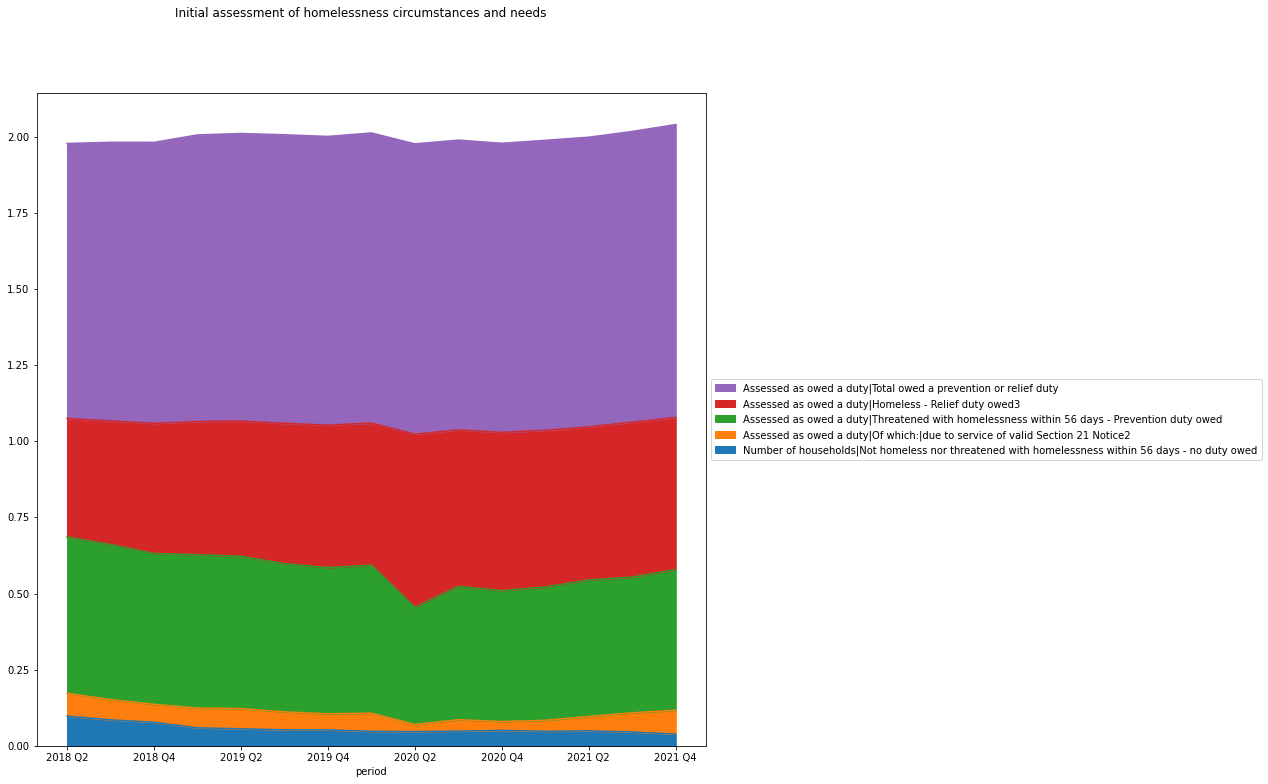

In [3]:
plot_reasons(live_tables_file)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Ethnicity : Total Applicants'}, xlabel='period'>)

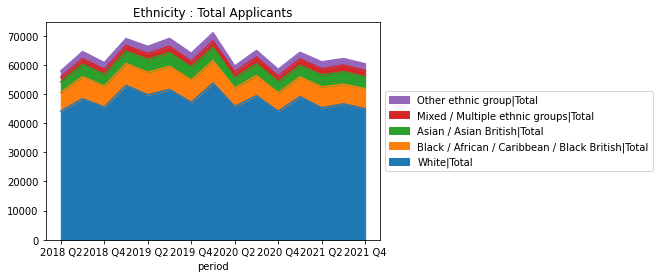

In [4]:
plot_ethnicity(live_tables_file)

<AxesSubplot:>

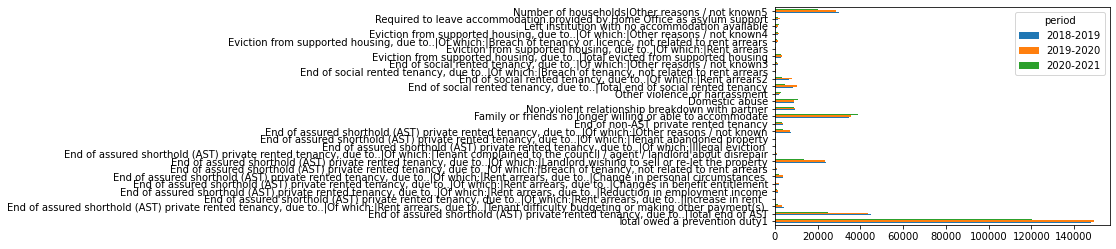

In [6]:
get_clean_stats(live_tables_file, period='year',
                sheet=get_sheets(live_tables_file)['Reason for threat of loss of last settled home']
               ).T.plot(kind='barh')

# REGIONAL FILES

In [ ]:
files = get_files('02 cleaned_data')
files

In [ ]:
dfs = [pd.read_csv(f) for f in files]

In [ ]:
df = pd.concat(dfs,ignore_index=True)

# format dates and strings
for col in df.select_dtypes('object'):
    # dates
    if df[col].apply(lambda x:True if len(x) == 10 and x[4]=='-' and x[7]=='-' else False).sum() > 0:
        df[col] = pd.to_datetime(df[col]).dt.date

    # strings
    else:
        df[col] = df[col].str.strip().str.title()
        
# sort fields hierarchically
df = df.sort_values(['period_end','region_type','LA_Code']).reset_index().drop(columns='index')
df.head(3)

In [ ]:

def get_survey_results(df, la_name='England'):
    """Important consideration:
    These figures are based on those that applied for prevention or homelessness relief duty.
    There could be many others that did not apply for whatever reason - eg:
        distrust of local authorities, 
        access to medical care forms/the means/knowhow to get the forms etc
        fears around immigration status that might be triggered when filling out the form
        etc etc
    
    We should look at other factors to understand the true number of homeless too.eg:
        street surveys.
        charity estimates
        food bank surveys?
    """
    
    renamed = df.rename(columns={
        'Threatened with homelessness - Prevention duty owed':'applicant at risk',
        'Homeless - Relief duty owed':'applicant homeless'
    }).copy()
    
    output = renamed.query(f"LA_Name == '{la_name}'").set_index('period_end')[[
        'applicant at risk','applicant homeless']].drop_duplicates()
    
    return output

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10,4))

gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1])
ax31 = fig.add_subplot(gs[0,2])
ax32 = fig.add_subplot(gs[1,2])

chart_ylim = {}

# first 2 plots
original_plots = {ax1:'applicant at risk',ax2:'applicant homeless'}
for a,lab in original_plots.items():
    # data
    d_tmp = get_survey_results(df)[lab]
    
    # plot line
    a.plot(d_tmp, label=lab)
    a.set_title(lab)

    # set ylimit
    mean_yval = d_tmp.mean()
    orders_mag = len(str(int(mean_yval))) - 1
    y_lim_rounded = round(mean_yval * 2, - orders_mag)
    chart_ylim[lab] = y_lim_rounded
    
    a.set_ylim(0, chart_ylim[lab])
    

# ZOOMED IN subplots
zoomed_plots = {ax31:'applicant at risk',ax32:'applicant homeless'}
for a,lab in zoomed_plots.items():
    # data
    d_tmp = get_survey_results(df)[lab]
    
    # plot line
    a.plot(d_tmp)
    
    # legend
    a.legend([lab], loc='center left',bbox_to_anchor=[1,0.5])
    
    # connection arrows:
    draw_from = {v:k for k,v in original_plots.items()}.get(lab)
    y_arrow_pos = d_tmp.iloc[-3:].mean() / chart_ylim[lab]
    con = mpl.patches.ConnectionPatch(xyA=(0.8,y_arrow_pos), xyB=(0.3,0.5), 
                                      coordsA='axes fraction', coordsB='axes fraction',
                                      axesA=draw_from, axesB=a,
                                     arrowstyle='->', color="crimson", lw=3)
    fig.add_artist(con)

fig.show()

In [ ]:
#testing gridspec - annotating, separating subplots and testing colour styles

for sty in plt.style.available:
    with plt.style.context(sty, after_reset=True):
        
        fig = plt.figure(tight_layout=True, figsize=(5,5))

        gs = fig.add_gridspec(5,5)

        ax1 = fig.add_subplot(gs[:2,:2])
        ax2 = fig.add_subplot(gs[2:,2:])

        tmp_d = get_survey_results(df)['applicant homeless']
        ax1.plot(tmp_d)

        # set ylimit
        mean_yval = tmp_d.mean()
        orders_mag = len(str(int(mean_yval))) - 1
        y_lim_rounded = round(mean_yval * 2, - orders_mag)
        ax1.set_ylim(0, y_lim_rounded)

        ax2.plot(tmp_d)

        arc_style = mpl.patches.ConnectionStyle.Arc3(rad=-0.2)
        con = mpl.patches.ConnectionPatch(xyA=(0.9,0.2),
            xyB=(0.2,0.9),
            coordsA='axes fraction',
            coordsB='axes fraction',
            axesA=ax1,
            axesB=ax2,
            arrowstyle='->',
            connectionstyle=arc_style)
        fig.add_artist(con)

        ax1.set_title('equal yscale from zero')
        ax2.set_title('zoomed in')

        #annotate in the blank spaces around the charts
        ax3 = fig.add_subplot(gs[:2,2:])
        ax3.set_axis_off()
        ax3.annotate('Zooming in reveals more detail',
                     xy=(0,0.2), xycoords='axes fraction')

        ax2.annotate('Applicant\'s that met criteria \nfor being Homeless',
                     xy=(0.5,0.4), xycoords='axes fraction')

        fig.suptitle(sty)
        fig.show()

REGIONAL HOMELESSNESS

In [ ]:
fig,ax = plt.subplots()
with plt.style.context('seaborn-colorblind'):
    macro_regions = joined[joined.region_type=='2 Regions'].groupby('LA_Name').sum().sort_values(
    'Total households assessed as owed a duty').index
    
    for k,v in {x: get_survey_results(joined,la_name=x) for x in macro_regions}.items():
        plt.plot(v['applicant homeless'],label=k)

    ax.set_title('applicant homeless')
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=[1,0.5])

In [ ]:
df

In [ ]:
countries = df[df['region_type'] == '1 Countries'].copy()
regions = df[df['region_type'] == '2 Regions'].copy()
authorities = df[df['region_type'] == '3 Authorities'].copy()

In [ ]:
countries[countries['LA_Name'] == 'England']

In [ ]:
with plt.style.context('ggplot'):
    (eng['Total households assessed as owed a duty'] / eng['Total number of households assessed1,2']).plot()
    plt.title('Total households assessed as owed a duty % of those assessed')

In [ ]:
with plt.style.context('ggplot'):
    (eng['Threatened with homelessness - Prevention duty owed'] / eng['Total number of households assessed1,2']).plot()
    plt.title('proportion of households assessed as being owed a duty is increasing')

In [ ]:
with plt.style.context('ggplot'):
    (eng['Homeless - Relief duty owed'] / eng['Total number of households assessed1,2']).plot()
    plt.title('Homeless - Relief duty owed - % of all assessed')
    
    

In [ ]:
eng = countries[countries['LA_Name'] == 'England']
print('eng % of assessed homeless',
      (eng['Total households assessed as owed a duty'] /eng['Total number of households assessed1,2']))
print('eng % of all hh homeless',
      (eng['Total households assessed as owed a duty'] /(eng['Number of households in area5 (000s)']*1000))[0])

In [ ]:
#REGIONAL
fig,axes = plt.subplots(ncols=2, figsize=(12,5),sharey=True)
ax=axes[0]
regions.set_index('LA_Name')['Households assessed as homelessper (000s)'].sort_values().iloc[::-1].plot(
    kind='barh',ax=ax)
ax.set_title('Assessed as homeless\nper 1000')

ax=axes[1]
regions.set_index('LA_Name').sort_values('Households assessed as homelessper (000s)')[
    'Households assessed as threatened with homelessnessper (000s)'].iloc[::-1].plot(
    kind='barh',ax=ax)
ax.set_title('Threatened with homelessness\nper 1000')


fig.tight_layout()
fig.show()

In [ ]:
#WORST HIT LOCAL AUTHORITIES
fig,axes = plt.subplots(ncols=2, figsize=(12,5),sharey=True)

d = authorities.set_index('LA_Name').sort_values('Households assessed as homelessper (000s)').iloc[::-1,-5:].dropna().copy()

ax=axes[0]
d['Households assessed as homelessper (000s)'].plot(kind='barh',ax=ax)
# authorities.set_index('LA_Name')['Households assessed as homelessper (000s)'].sort_values().iloc[::-1].plot(
#     kind='barh',ax=ax)
ax.set_title('Assessed as homeless\nper 1000')

ax=axes[1]
d['Households assessed as threatened with homelessnessper (000s)'].plot(kind='barh',ax=ax)
# authorities.set_index('LA_Name').sort_values('Households assessed as homelessper (000s)')[
#     'Households assessed as threatened with homelessnessper (000s)'].iloc[::-1].plot(
#     kind='barh',ax=ax)
ax.set_title('Threatened with homelessness\nper 1000')


fig.tight_layout()
fig.show()

MOST HOMELESS

In [ ]:
d['Households assessed as homelessper (000s)'].sort_values().iloc[::-1].head(10)

MOST AT RISK

In [ ]:
d['Households assessed as threatened with homelessnessper (000s)'].sort_values().iloc[::-1].head(10)

Cross reference with other regional data - eg hh income edu, health risks etc etc?